# 데이터 품질 확인 및 전처리

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
import os

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

!pip install koreanize-matplotlib
import koreanize_matplotlib

In [3]:
path = '/content/drive/MyDrive/Colab Notebooks/DA(AI)/kaggle_cosmetics/kaggle_combined_file.csv' # 결합한 kaggel 데이터 불러오기

In [4]:
pd.read_csv(path)
df = pd.read_csv(path)

## 데이터탐색

In [5]:
df1 = df.copy()
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20692840 entries, 0 to 20692839
Data columns (total 9 columns):
 #   Column         Dtype  
---  ------         -----  
 0   event_time     object 
 1   event_type     object 
 2   product_id     int64  
 3   category_id    int64  
 4   category_code  object 
 5   brand          object 
 6   price          float64
 7   user_id        int64  
 8   user_session   object 
dtypes: float64(1), int64(3), object(5)
memory usage: 1.4+ GB


In [8]:
df1.isnull().sum()

event_time              0
event_type              0
product_id              0
category_id             0
category_code    20339246
brand             8757117
price                   0
user_id                 0
user_session         4598
dtype: int64

In [7]:
df1['event_time'].value_counts()

2020-02-15 16:08:37 UTC    3087
2020-02-05 09:55:55 UTC    2067
2020-02-06 18:10:38 UTC    1982
2020-02-05 09:55:40 UTC    1892
2020-02-15 16:08:56 UTC    1075
                           ... 
2019-10-13 00:27:19 UTC       1
2019-10-13 00:27:17 UTC       1
2019-10-13 00:27:16 UTC       1
2019-10-13 00:27:13 UTC       1
2020-01-31 23:59:58 UTC       1
Name: event_time, Length: 8782890, dtype: int64

- 2019.10월부터 2020.02월까지의 데이터 임을 알 수 있다

In [9]:
df1['event_type'].value_counts()

view                9657821
cart                5768333
remove_from_cart    3979679
purchase            1287007
Name: event_type, dtype: int64

In [10]:
df1['product_id'].value_counts()

5809910    141650
5809912     55606
5700037     51111
5802432     45008
5854897     44799
            ...  
5815775         1
5688893         1
5568096         1
5701709         1
5682848         1
Name: product_id, Length: 54571, dtype: int64

In [11]:
df1['category_id'].value_counts()

1487580007675986893    1062716
1487580005595612013     789465
1487580005092295511     770985
1487580005671109489     680648
1487580006317032337     646704
                        ...   
1487580007155893175          2
1487580009890578479          1
1487580010897211483          1
1487580011056595041          1
1487580009706029097          1
Name: category_id, Length: 525, dtype: int64

In [12]:
df1['category_code'].value_counts()

appliances.environment.vacuum             149168
stationery.cartrige                        59728
apparel.glove                              52575
furniture.living_room.cabinet              30560
accessories.bag                            24253
furniture.bathroom.bath                    23931
appliances.personal.hair_cutter             5384
accessories.cosmetic_bag                    3644
appliances.personal.massager                3296
appliances.environment.air_conditioner       708
furniture.living_room.chair                  343
sport.diving                                   4
Name: category_code, dtype: int64

- 카테고리 코드의 경우에는 대분류>중분류>소분류가 '.'으로 연결되어 있는 형태를 띠고 있다.
- 그러나 카테고리 명이 화장품 매장의 데이터로는 보이지 않는다.

이를 자세히 확인해보자

### 가정1. 이전엔 다른 매장이었다가 화장품 매장으로 바뀐 것은 아닐까?

해당 category_code의 event_time이 한 쪽으로 쏠려있진 않은 지를 확인해 본 뒤 category_id가 엽치는 지 확인해보자

In [13]:
# event_time이 object 형으로 저장되어 있기 때문에 날짜 형으로 바꾸고 날짜로만 확인하도록 하자

df1['event_date'] = pd.to_datetime(df1['event_time']).dt.date

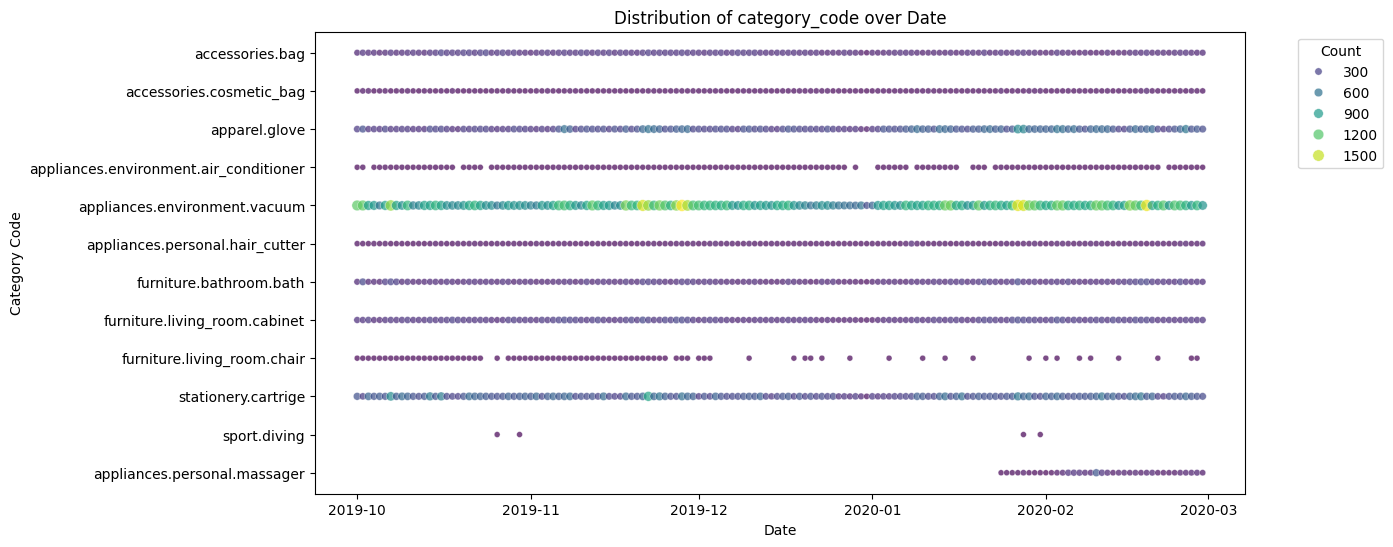

In [15]:
category_code_counts = df1.groupby(['event_date', 'category_code']).size().reset_index(name='count')

plt.figure(figsize=(12, 6))
sns.scatterplot(x='event_date', y='category_code', size='count', data=category_code_counts, hue='count', palette='viridis', alpha=0.7)
plt.title('Distribution of category_code over Date')
plt.xlabel('Date')
plt.ylabel('Category Code')
plt.legend(title='Count', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

- 확인결과 날짜별 분포를 보면 전체 데이터동안 발생한 값이라는 것을 알 수 있다.

### 가정2. 그럼 동시간에 다른 데이터가 합쳐진 것일까?
category_code와 category_id, product_id를 서로 비교해보자

In [36]:
# category_code가 결측치로 된 데이터와 아닌 데이터로 나누어 category_id 확인

categorycode_df = df1.dropna(subset=['category_code']) # category_code 데이터가 존재하는 데이터
no_categorycode_df = df1[df1['category_code'].isnull()] # category_code 데이터가 존재하지 않는 데이터

In [37]:
# 각 데이터 세트에서 category_id의 고유값 추출
id_with_code = set(categorycode_df['category_id'])
id_without_code = set(no_categorycode_df['category_id'])

# 두 세트의 category_id 고유값들의 교집합 구하기
intersection = id_with_code.intersection(id_without_code)

# 결과 출력
if intersection:
    print(f"겹치는 category_id 존재: {intersection}")
else:
    print("겹치는 category_id가 없음")

겹치는 category_id가 없음


- category_id는 결측치 있는 행과 없는 행 간의 중복은 존재하지 않음을 확인했다.

이제 product_id와 비교해보자  
category_code가 있는/없는 행의 product_id가 겹치는 지 확인하자

In [38]:
# 각 데이터 세트에서 product_id의 고유값 추출
p_id_with_code = set(categorycode_df['product_id'])
p_id_without_code = set(no_categorycode_df['product_id'])

# 두 세트의 product_id 고유값들의 교집합 구하기
intersection = p_id_with_code.intersection(p_id_without_code)

# 결과 출력
if intersection:
    print(f"겹치는 product_id 존재: {intersection}")
else:
    print("겹치는 product_id 없음")

겹치는 product_id 존재: {5712520, 5877529, 5856184, 5712518}


In [39]:
# 데이터프레임을 통해 자세히보자
result_df =df1[df1['product_id'].isin(intersection)]
result_df = result_df.sort_values(by='product_id')
result_df

,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session
11332605,2019-10-29 13:48:31 UTC,remove_from_cart,5712518,1487580009445982239,NaN,NaN,8.89,414152930,40c3e333-2318-4156-a058-5400140c0306
9724280,2019-10-16 04:17:31 UTC,view,5712518,1487580009445982239,NaN,NaN,8.89,558289943,4d14bc09-fcf1-4f6a-b1af-921fb47f2cc8
9673177,2019-10-15 15:48:16 UTC,remove_from_cart,5712518,1487580009445982239,NaN,NaN,8.89,551830532,bb8eaa34-6c64-4f72-98e1-356c0cdc1698
9667291,2019-10-15 14:47:00 UTC,remove_from_cart,5712518,1487580009445982239,NaN,NaN,8.89,480166129,4ed637f7-a350-4305-ace5-8d4c63523122
9666086,2019-10-15 14:37:51 UTC,cart,5712518,1487580009445982239,NaN,NaN,8.89,480166129,4ed637f7-a350-4305-ace5-8d4c63523122
...,...,...,...,...,...,...,...,...,...
11559093,2019-10-31 11:31:28 UTC,view,5877529,1487580010645553231,NaN,jessnail,98.41,566098023,2b2c6bae-c6d7-4b2c-a44b-1be9fd82a7eb
3439843,2019-11-01 19:00:01 UTC,view,5877529,1487580010645553231,NaN,jessnail,98.41,526638162,1ce92b45-e242-4b95-9842-806eb5de67a5
7773191,2019-10-01 09:35:45 UTC,view,5877529,1487580010645553231,NaN,jessnail,98.41,536640765,fa5a9f0d-5c5c-4286-be68-a17232c4c0ab
11542464,2019-10-31 09:19:13 UTC,view,5877529,1487580010645553231,NaN,jessnail,98.41,565317022,cffbed9c-6e2c-4522-be77-8b583f6d5f7d


- product_id가 다른 값끼리 category_id와 code의 결측치 유무가 갈라지는 것을 확인할 수 있다.
- 즉 다른 상품 두 가지가 같은 category_id를 공유하고 있었고 product_id가 나뉘는 대로 category_code의 값도 나뉘었다.

- 이를 통해, 날짜와 관계없이 다른 매장의 데이터가 합쳐진 것을 알 수 있다.  
전처리 과정에서 값이 존재하는 행은 삭제한 뒤 컬럼을 제거하면 될 것 같다.

마저 컬럼을 살펴보자

In [20]:
df1['brand'].value_counts()

runail       1528908
irisk        1033852
masura        861763
grattol       852591
bpw.style     434813
              ...   
shifei             9
vl-gel             7
dessata            6
gena               3
pueen              1
Name: brand, Length: 273, dtype: int64

- 총 273개의 브랜드(이벤트가 일어난 데이터 중)

In [21]:
df1['price'].value_counts()

5.24     620768
3.97     598502
0.79     541460
3.00     529433
4.44     501977
          ...  
34.68         1
19.70         1
39.27         1
19.22         1
53.49         1
Name: price, Length: 2860, dtype: int64

In [5]:
# price의 범위를 확인해보자
df1.sort_values(by='price')

,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session
4283228,2019-11-06 17:31:51 UTC,purchase,5716861,1487580014042939619,NaN,NaN,-79.37,554241372,b85719db-2c56-460b-b800-d7a47d4c4d70
17408753,2020-01-09 14:40:47 UTC,purchase,5716861,1487580014042939619,NaN,NaN,-79.37,598762179,d23c8c3c-3e9f-4e2a-8636-42b4fc501ce3
17952565,2020-01-13 13:03:15 UTC,purchase,5716861,1487580014042939619,NaN,NaN,-79.37,489184067,36f0ade4-fe9f-4353-9ddb-a6600e11b314
10093195,2019-10-14 17:33:24 UTC,purchase,5716861,1487580014042939619,NaN,NaN,-79.37,541122983,b60f777d-afca-4299-8548-273b810d6130
3403149,2019-12-29 14:30:17 UTC,purchase,5716861,1487580014042939619,NaN,NaN,-79.37,489118334,da505a6f-d98d-4284-84ba-cc1873f5f8ad
...,...,...,...,...,...,...,...,...,...
7180702,2019-11-25 08:11:59 UTC,view,5906221,1487580006300255120,NaN,strong,327.78,575102728,bf01cd3b-9f83-4d1a-9b47-33d49fbea648
7214655,2019-11-25 12:27:59 UTC,view,5906221,1487580006300255120,NaN,strong,327.78,518138868,3011d3cf-7218-4d26-8549-5089ca771d5e
19046685,2020-01-20 20:40:57 UTC,view,5906221,1487580006300255120,NaN,strong,327.78,580797367,67f2f7af-2707-4bc7-a732-dfb744239969
345277,2019-12-03 15:13:13 UTC,view,5906221,1487580006300255120,NaN,strong,327.78,574363037,80eb5d21-499c-4d9d-8031-a80056ae3c70


- price 값이 음수값이 131개 존재한다... 심지어 0인 값도 꽤 많이 존재한다는 것을 알 수 있다.
- 만약, 음수값이 모두 purchase에 해당하는 가격이라면 환불 데이터일 수 있지 않을까? 아니라면 이상치이거나 오입력된 데이터인지 확인해야한다.  
우선, 음수값은 5개를 제외하고는 purchase데이터였다.view 2개, remove_from_cart 3개
- 0인 값은 모두 view 데이터(또는 cart, remove_from_cart)에 속하면 view는 수익이 일어나지 않은 데이터라.. 그런게 아닐까하는 희망을 가져본다.

In [15]:
# pirce가 음수값인 데이터가 환불데이터인지 확인해보기

## 음수 price 값을 가지는 데이터 선택
negative_prices = df1[df1['price'] < 0]

check_results = [] # 확인 결과를 저장할 빈 리스트

for index, row in negative_prices.iterrows():
    abs_price = abs(row['price'])
    product_id = row['product_id']
    user_id = row['user_id']

    # 조건에 맞는 데이터가 있는지 확인
    exists = df1[(df1['price'] == abs_price) & (df1['product_id'] == product_id) & (df1['user_id'] == user_id)].any().any()

    # 확인 결과를 리스트에 추가
    check_results.append({
        'product_id': product_id,
        'user_id': user_id,
        'price': row['price'],
        'refund_matched': exists
    })

refund_checks_df = pd.DataFrame(check_results)
refund_checks_df

,product_id,user_id,price,refund_matched
0,5670257,410016187,-15.87,False
1,5670257,579811230,-15.87,False
2,5716859,414087247,-47.62,False
3,5716857,584773479,-23.81,False
4,5670257,584498077,-15.87,False
...,...,...,...,...
126,5716859,605668162,-47.62,False
127,5716861,606448681,-79.37,False
128,5716861,531900924,-79.37,False
129,5716859,544827743,-47.62,False


- 환불 데이터는 아니었던 것 같다. 해당 음수 값들은 모두 삭제해주자  
양수값인데 음수로 입력되었을 가능성도 있지만 수가 적어 미미한 영향을 주기에 이상치로 판단하고 삭제하기로 결정하였다.

다음으론 0인 값을 확인하자

In [6]:
# price가 0인 값의 event_type 확인하기
price_0 = df1[df1['price'] == 0]

event_type_counts = price_0['event_type'].value_counts()

print(event_type_counts)

cart                49370
view                30490
remove_from_cart    24296
purchase                1
Name: event_type, dtype: int64


In [12]:
len(price_0)

104157

- 데이터 개수를 통해 가격이 0인 값이 purchase를 제외한 전부이길 바랬지만 가정은 틀렸다는 것을 확인할 수 있다.
- 가격이 0인 값이 10만개로 전체 데이터의 0.5%에 속한다. 0인 값을 제거시켜야할지 고민이다.

그렇다면, 이번엔 event_type별로 가격의 분포를 확인보자

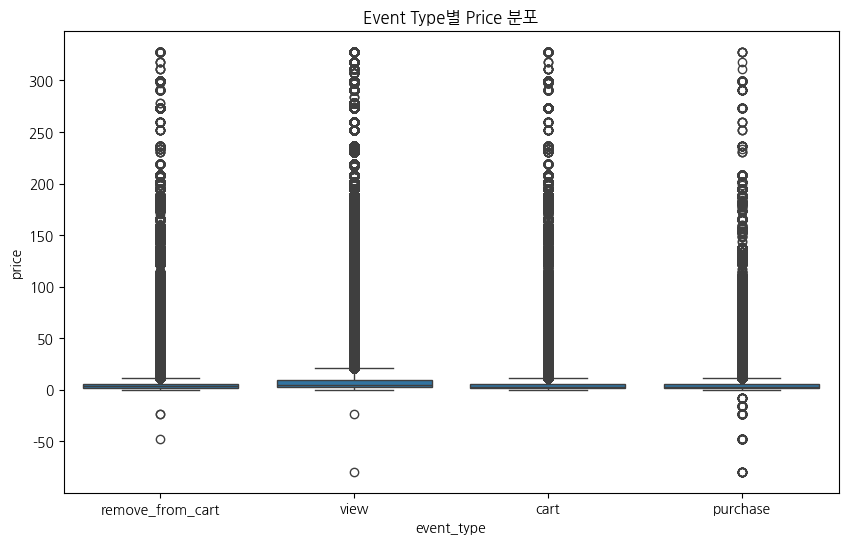

In [10]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='event_type', y='price', data=df1)
plt.title('Event Type별 Price 분포')
plt.show()

- 가격이 0 근처에서 분포가 가장 많으나 타입별로 가격이 다양하게 분포하는 것을 확인할 수 있다.

0인 값을 제거한 값의 price 분포도 확인해보자

In [5]:
price_without_0 = df1[df1['price'] > 0]

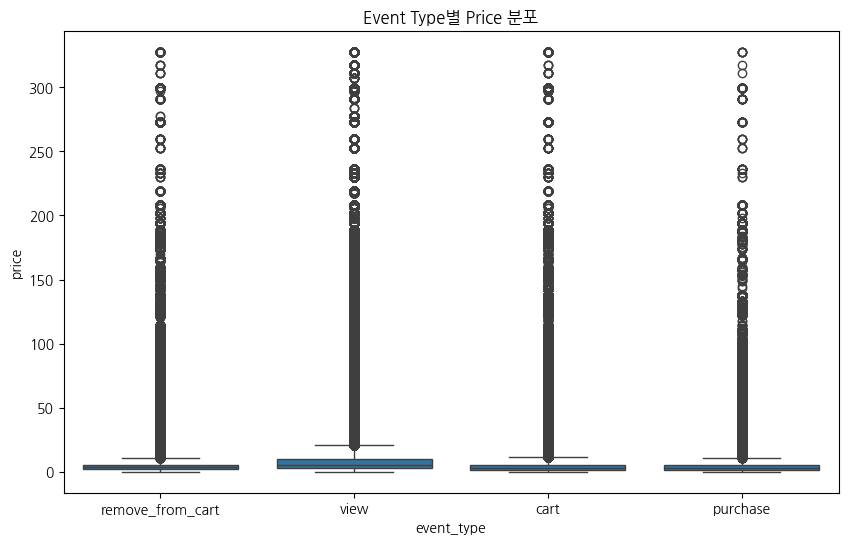

In [6]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='event_type', y='price', data=price_without_0)
plt.title('Event Type별 Price 분포')
plt.show()

In [7]:
price_without_0.sort_values(by='price')

,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session
9720169,2019-10-11 14:55:13 UTC,view,5603934,1487580007717929935,NaN,NaN,0.05,455341424,cc9c22a7-6a42-4dc1-aa5a-cae951a1f15b
8556640,2019-10-03 10:33:19 UTC,view,5603937,1487580007717929935,NaN,NaN,0.05,547276297,467fc8b0-3e52-4c53-b005-e6b62e4596bf
19981042,2020-01-27 13:34:39 UTC,remove_from_cart,5603933,1487580007717929935,NaN,NaN,0.05,601567245,3efded6e-d6f3-4b5a-a5bd-a7b8bef58087
16851215,2020-01-05 04:15:30 UTC,cart,5603937,1487580007717929935,NaN,NaN,0.05,459027394,02390c28-f6ac-43e9-a53a-99473a322d19
16851212,2020-01-05 04:15:28 UTC,cart,5603934,1487580007717929935,NaN,NaN,0.05,459027394,02390c28-f6ac-43e9-a53a-99473a322d19
...,...,...,...,...,...,...,...,...,...
18770405,2020-01-18 23:52:40 UTC,view,5906221,1487580006300255120,NaN,strong,327.78,437348045,5c370b16-f6fc-fbba-eda0-d0487a790b08
18529525,2020-01-17 06:34:46 UTC,view,5906221,1487580006300255120,NaN,strong,327.78,529082537,cd51457d-0217-402e-85d5-73a908962424
17133704,2020-01-07 14:33:03 UTC,view,5906221,1487580006300255120,NaN,strong,327.78,537649750,c81860ed-486b-4ac4-aade-1e28db316543
7507915,2019-11-27 14:05:24 UTC,view,5906221,1487580006300255120,NaN,strong,327.78,370929640,8e038b17-0c1a-44a9-9b48-3d0d8ffb2dd3


In [8]:
price_counts_df = price_without_0['price'].value_counts().reset_index()
price_counts_df.columns = ['Unique Prices', 'Count']

price_counts_df = price_counts_df.sort_values('Unique Prices')

pd.DataFrame(price_counts_df)

,Unique Prices,Count
542,0.05,3801
400,0.06,6575
525,0.08,3992
852,0.10,1274
885,0.11,1150
...,...,...
307,299.81,9795
2613,307.60,12
1821,311.38,121
1347,317.46,349


from matplotlib import pyplot as plt
_df_0['Unique Prices'].plot(kind='hist', bins=20, title='Unique Prices')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_1['Count'].plot(kind='hist', bins=20, title='Count')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_2.plot(kind='scatter', x='Unique Prices', y='Count', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['Unique Prices']
  ys = series['Count']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_3.sort_values('Unique Prices', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('Unique Prices')
_ = plt.ylabel('Count')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['Unique Prices']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'Unique Prices'}, axis=1)
              .sort_values('Unique Prices', ascending=True))
  xs = counted['Unique Prices']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_4.sort_values('Unique Prices', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('Unique Prices')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
_df_5['Unique Prices'].plot(kind='line', figsize=(8, 4), title='Unique Prices')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_6['Count'].plot(kind='line', figsize=(8, 4), title='Count')
plt.gca().spines[['top', 'right']].set_visible(False)

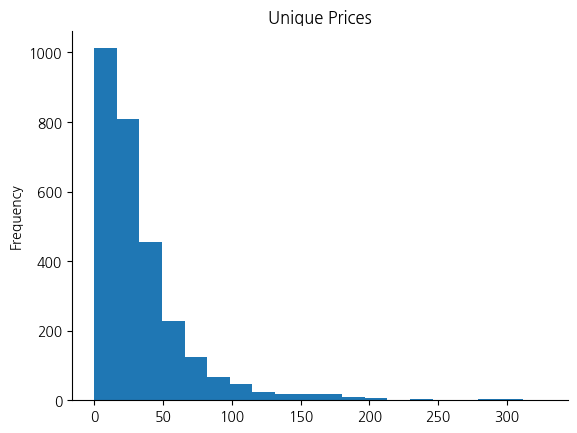

In [9]:
from matplotlib import pyplot as plt
price_counts_df['Unique Prices'].plot(kind='hist', bins=20, title='Unique Prices')
plt.gca().spines[['top', 'right',]].set_visible(False)

- 0을 제외하고서도 price 데이터가 너무 낮은 값들로 시작한다. 해당 데이터의 event_time을 보면 UTC 시간대로 표시되어 있기 때문에 그 기준이 되는 영국을 국적으로 가정했다. brand명으로도 국가를 살펴보았지만 러시아, 중국, 스웨덴, 미국 등 다양한 국적의 브랜드로 나왔기 때문에 브랜드로 국가를 지정하기는 어려움이 있었다.

- 따라서 영국으로 설정했는데, 돈의 단위가 너무 적게 나온다. 최대 값으로 본다면 한화 55만원 정도로 화장품 가격으로 적절하다 생각했는데 최소 금액이 맞지 않는다.
- 아마도 해당 pirce 데이터는 변환된 값이 아닐까? 0인 값을 제거하는 것이 의미있는 행동이 아니기에 음수값만 제거하기로 결정했다.

In [9]:
df1['user_id'].value_counts()

527021202    26752
557616099     9903
583884978     9420
419558969     8283
476450673     8122
             ...  
583616620        1
548465166        1
565377447        1
548451124        1
560889817        1
Name: user_id, Length: 1639358, dtype: int64

In [10]:
df1['user_session'].value_counts()

74206ba1-c863-4760-bbdc-b11777059e46    5411
dee05e29-f331-48dc-b1b3-547985fc2aa4    5323
d7998d70-7562-4ff0-8870-5ace290db2c9    4193
a062f07b-4eef-4266-8660-b3040ed412aa    4037
ec5821ee-396d-4b72-a89b-50aea5b0847b    3785
                                        ... 
c3d9556d-036b-4b1d-8448-a6b72ce13355       1
e401824b-6728-49c7-8b5a-0d59e2756507       1
04816d12-04f9-4be1-9257-15e07cefe67a       1
ce1d9da0-7b7a-4c5c-a709-9ffb9702fea5       1
fc7063a6-b45e-4863-babb-da4934b83388       1
Name: user_session, Length: 4535941, dtype: int64

- user_session도 전체 값의 2%정도이지만 결측치가 존재했었다.  
session의 특성상 중복으로(페이지 대기 상태의 세션 만료?) 데이터가 생겨서 결측치가 생긴 것은 아닌지 확인해보자

In [10]:
# 먼저 기존 데이터의 중복값이 있는지 보기
df1.duplicated(keep=False).sum()

2154860

- 약 10%의 데이터가 중복값으로 존재한다.  
세션을 포함해 같은 값이면 제거해주어야 할까? 아니면 동시에 일어난 값(여러개 주문 시 발생하는)은 세션도 같을까?

확인해보자

In [11]:
duplicate_df = df1.duplicated(keep=False)

In [13]:
duplicate_df = df1[duplicate_df]

In [16]:
duplicate_df['event_type'].value_counts()

remove_from_cart    1945208
cart                 205844
view                   2000
purchase               1808
Name: event_type, dtype: int64

- view가 있는 것으로 봐선 여러 개의 값이 따로 입력되어 중복값이 생긴 것으로 보이진 않는다.
중복값은 삭제하자

In [26]:
# user_session 컬럼의 결측치가 페이지 대기로 인한, 반복에 의한 결측치인지 확인하기

df1_1 = df1.drop_duplicates(keep='first') # 기존데이터의 중복값을 삭제한 뒤 확인하기

df_without_session = df1_1[df1_1['user_session'].isnull()] # 세션이 결측치인 값
df1_1 = df1.columns.drop('user_session') # 세션 컬럼 제거

duplicates = df_without_session.duplicated(subset=df1_1, keep=False)

if duplicates.any():
    print("결측치 데이터와 중복되는 값 존재.")
    print(df_without_session[duplicates])
else:
    print("결측치 데이터와의 중복값 존재하지 않음")

결측치 데이터와의 중복값 존재하지 않음


- user_session의 결측치도 페이지 대기로 인한 것이 아닌 그저 세션이 입력이 되지 않아 발생한 결측치였다.  
따라서 해당 결측치는 삭제하지 않고 결측치를 없애기 위해 'session'으로 채워주기로 한다.
이후 컬럼이 필요하지 않을 때 삭제하면 될 것 같다.

### 데이터 탐색 결과

- 정확성 : 다른 매장의 데이터가 존재했음
- 완전성 : price에서 이상치가 존재했고, brand와 user_session에서 결측치가 존재했음
- 고유성 : 중복값이 전체 데이터의 약 10% 존재
- 피트니스 : price의 값들이 이미 변환된 데이터라고 추측됨

약 네 가지 측면에서 데이터 품질에 문제가 있어 이를 개선하기 위한 데이터 전처리를 실행한다.

## 데이터 전처리

### 1. 이상치 제거 : price

In [6]:
# price가 음수인 값 제거하기
df1 = df1[df1['price'] >= 0]
df1

,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session
0,2019-12-01 00:00:00 UTC,remove_from_cart,5712790,1487580005268456287,NaN,f.o.x,6.27,576802932,51d85cb0-897f-48d2-918b-ad63965c12dc
1,2019-12-01 00:00:00 UTC,view,5764655,1487580005411062629,NaN,cnd,29.05,412120092,8adff31e-2051-4894-9758-224bfa8aec18
2,2019-12-01 00:00:02 UTC,cart,4958,1487580009471148064,NaN,runail,1.19,494077766,c99a50e8-2fac-4c4d-89ec-41c05f114554
3,2019-12-01 00:00:05 UTC,view,5848413,1487580007675986893,NaN,freedecor,0.79,348405118,722ffea5-73c0-4924-8e8f-371ff8031af4
4,2019-12-01 00:00:07 UTC,view,5824148,1487580005511725929,NaN,NaN,5.56,576005683,28172809-7e4a-45ce-bab0-5efa90117cd5
...,...,...,...,...,...,...,...,...,...
20692835,2020-01-31 23:59:52 UTC,remove_from_cart,5886774,1487580006317032337,NaN,NaN,1.59,607092857,a4ccd1c4-a9d2-48d0-9816-082ec5bb5e47
20692836,2020-01-31 23:59:52 UTC,remove_from_cart,5886774,1487580006317032337,NaN,NaN,1.59,607092857,a4ccd1c4-a9d2-48d0-9816-082ec5bb5e47
20692837,2020-01-31 23:59:53 UTC,view,5875432,2084144451428549153,NaN,NaN,2.05,423651741,fb42a963-abef-4c4f-b1ba-f5812dd54e80
20692838,2020-01-31 23:59:57 UTC,remove_from_cart,5820745,1487580006317032337,NaN,NaN,2.22,607092857,a4ccd1c4-a9d2-48d0-9816-082ec5bb5e47


### 2. 중복값 제거

In [7]:
df1 = df1.drop_duplicates() # 중복값 제거
df1

,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session
0,2019-12-01 00:00:00 UTC,remove_from_cart,5712790,1487580005268456287,NaN,f.o.x,6.27,576802932,51d85cb0-897f-48d2-918b-ad63965c12dc
1,2019-12-01 00:00:00 UTC,view,5764655,1487580005411062629,NaN,cnd,29.05,412120092,8adff31e-2051-4894-9758-224bfa8aec18
2,2019-12-01 00:00:02 UTC,cart,4958,1487580009471148064,NaN,runail,1.19,494077766,c99a50e8-2fac-4c4d-89ec-41c05f114554
3,2019-12-01 00:00:05 UTC,view,5848413,1487580007675986893,NaN,freedecor,0.79,348405118,722ffea5-73c0-4924-8e8f-371ff8031af4
4,2019-12-01 00:00:07 UTC,view,5824148,1487580005511725929,NaN,NaN,5.56,576005683,28172809-7e4a-45ce-bab0-5efa90117cd5
...,...,...,...,...,...,...,...,...,...
20692834,2020-01-31 23:59:52 UTC,view,5796984,1487580005671109489,NaN,masura,1.73,417102560,dcf90ff3-a246-4b00-b39a-83e6444a0769
20692835,2020-01-31 23:59:52 UTC,remove_from_cart,5886774,1487580006317032337,NaN,NaN,1.59,607092857,a4ccd1c4-a9d2-48d0-9816-082ec5bb5e47
20692837,2020-01-31 23:59:53 UTC,view,5875432,2084144451428549153,NaN,NaN,2.05,423651741,fb42a963-abef-4c4f-b1ba-f5812dd54e80
20692838,2020-01-31 23:59:57 UTC,remove_from_cart,5820745,1487580006317032337,NaN,NaN,2.22,607092857,a4ccd1c4-a9d2-48d0-9816-082ec5bb5e47


In [8]:
df1.info() # 조정된 데이터 다시 확인하기

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19583618 entries, 0 to 20692839
Data columns (total 9 columns):
 #   Column         Dtype  
---  ------         -----  
 0   event_time     object 
 1   event_type     object 
 2   product_id     int64  
 3   category_id    int64  
 4   category_code  object 
 5   brand          object 
 6   price          float64
 7   user_id        int64  
 8   user_session   object 
dtypes: float64(1), int64(3), object(5)
memory usage: 1.5+ GB


In [9]:
# 인덱스 재정렬이 안 된 것을 확인하여 재정렬 해주었다
df1 = df1.reset_index(drop=True)
df1

,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session
0,2019-12-01 00:00:00 UTC,remove_from_cart,5712790,1487580005268456287,NaN,f.o.x,6.27,576802932,51d85cb0-897f-48d2-918b-ad63965c12dc
1,2019-12-01 00:00:00 UTC,view,5764655,1487580005411062629,NaN,cnd,29.05,412120092,8adff31e-2051-4894-9758-224bfa8aec18
2,2019-12-01 00:00:02 UTC,cart,4958,1487580009471148064,NaN,runail,1.19,494077766,c99a50e8-2fac-4c4d-89ec-41c05f114554
3,2019-12-01 00:00:05 UTC,view,5848413,1487580007675986893,NaN,freedecor,0.79,348405118,722ffea5-73c0-4924-8e8f-371ff8031af4
4,2019-12-01 00:00:07 UTC,view,5824148,1487580005511725929,NaN,NaN,5.56,576005683,28172809-7e4a-45ce-bab0-5efa90117cd5
...,...,...,...,...,...,...,...,...,...
19583613,2020-01-31 23:59:52 UTC,view,5796984,1487580005671109489,NaN,masura,1.73,417102560,dcf90ff3-a246-4b00-b39a-83e6444a0769
19583614,2020-01-31 23:59:52 UTC,remove_from_cart,5886774,1487580006317032337,NaN,NaN,1.59,607092857,a4ccd1c4-a9d2-48d0-9816-082ec5bb5e47
19583615,2020-01-31 23:59:53 UTC,view,5875432,2084144451428549153,NaN,NaN,2.05,423651741,fb42a963-abef-4c4f-b1ba-f5812dd54e80
19583616,2020-01-31 23:59:57 UTC,remove_from_cart,5820745,1487580006317032337,NaN,NaN,2.22,607092857,a4ccd1c4-a9d2-48d0-9816-082ec5bb5e47


### 3. 결측치 처리하기



#### category_code

먼저 category_code는 다른 매장의 데이터만 입력되고 해당 데이터는 입력되지 않았기 때문에 결측치가 존재하는 값만 남겨두고 컬럼을 삭제한다.

In [10]:
# 결측치 행만 남기기
df1 = df1[df1['category_code'].isnull()]

In [11]:
# 컬럼 삭제
df1 = df1.drop(['category_code'], axis =1)
df1

,event_time,event_type,product_id,category_id,brand,price,user_id,user_session
0,2019-12-01 00:00:00 UTC,remove_from_cart,5712790,1487580005268456287,f.o.x,6.27,576802932,51d85cb0-897f-48d2-918b-ad63965c12dc
1,2019-12-01 00:00:00 UTC,view,5764655,1487580005411062629,cnd,29.05,412120092,8adff31e-2051-4894-9758-224bfa8aec18
2,2019-12-01 00:00:02 UTC,cart,4958,1487580009471148064,runail,1.19,494077766,c99a50e8-2fac-4c4d-89ec-41c05f114554
3,2019-12-01 00:00:05 UTC,view,5848413,1487580007675986893,freedecor,0.79,348405118,722ffea5-73c0-4924-8e8f-371ff8031af4
4,2019-12-01 00:00:07 UTC,view,5824148,1487580005511725929,NaN,5.56,576005683,28172809-7e4a-45ce-bab0-5efa90117cd5
...,...,...,...,...,...,...,...,...
19583613,2020-01-31 23:59:52 UTC,view,5796984,1487580005671109489,masura,1.73,417102560,dcf90ff3-a246-4b00-b39a-83e6444a0769
19583614,2020-01-31 23:59:52 UTC,remove_from_cart,5886774,1487580006317032337,NaN,1.59,607092857,a4ccd1c4-a9d2-48d0-9816-082ec5bb5e47
19583615,2020-01-31 23:59:53 UTC,view,5875432,2084144451428549153,NaN,2.05,423651741,fb42a963-abef-4c4f-b1ba-f5812dd54e80
19583616,2020-01-31 23:59:57 UTC,remove_from_cart,5820745,1487580006317032337,NaN,2.22,607092857,a4ccd1c4-a9d2-48d0-9816-082ec5bb5e47


#### brand

brand의 결측치는 product_id와 비교하여 채울 것이다. 그 전에, product_id 당 하나의 브랜드가 입력되어있는 지 확인하자

In [12]:
df1_2 = df1.dropna(subset=['brand'], axis=0)
df1_2 # brand의 결측치 행을 제외한 값

,event_time,event_type,product_id,category_id,brand,price,user_id,user_session
0,2019-12-01 00:00:00 UTC,remove_from_cart,5712790,1487580005268456287,f.o.x,6.27,576802932,51d85cb0-897f-48d2-918b-ad63965c12dc
1,2019-12-01 00:00:00 UTC,view,5764655,1487580005411062629,cnd,29.05,412120092,8adff31e-2051-4894-9758-224bfa8aec18
2,2019-12-01 00:00:02 UTC,cart,4958,1487580009471148064,runail,1.19,494077766,c99a50e8-2fac-4c4d-89ec-41c05f114554
3,2019-12-01 00:00:05 UTC,view,5848413,1487580007675986893,freedecor,0.79,348405118,722ffea5-73c0-4924-8e8f-371ff8031af4
5,2019-12-01 00:00:09 UTC,view,5773361,1487580005134238553,runail,2.62,560109803,38cf4ba1-4a0a-4c9e-b870-46685d105f95
...,...,...,...,...,...,...,...,...
19583608,2020-01-31 23:59:42 UTC,view,5856738,1487580008246412266,joico,30.16,495404942,3a569c8d-d848-4f09-a925-33f673d84c46
19583609,2020-01-31 23:59:43 UTC,remove_from_cart,5751422,1487580005268456287,uno,10.95,607092857,a4ccd1c4-a9d2-48d0-9816-082ec5bb5e47
19583610,2020-01-31 23:59:44 UTC,view,5877031,1487580010100293687,milv,3.49,564814969,fc7063a6-b45e-4863-babb-da4934b83388
19583611,2020-01-31 23:59:47 UTC,view,5870076,1783999064136745198,grattol,5.71,583267679,2806ff10-08bc-4811-9ab7-af074fe22a88


In [13]:
# product_id 별 brand가 하나만 있는 지 확인해보자
brand_by_product_id = df1_2.groupby('product_id')['brand'].unique().reset_index()
pd.DataFrame(brand_by_product_id)

,product_id,brand
0,3752,[cnd]
1,3762,[cnd]
2,3763,[cnd]
3,3773,[entity]
4,3774,[cnd]
...,...,...
30691,5932581,[masura]
30692,5932582,[masura]
30693,5932583,[masura]
30694,5932584,[masura]


In [16]:
## 같은 product_id로 결측치 채우기
df1['brand'].fillna(df1.groupby('product_id')['brand'].transform('first'), inplace=True)
df1

,event_time,event_type,product_id,category_id,brand,price,user_id,user_session
0,2019-12-01 00:00:00 UTC,remove_from_cart,5712790,1487580005268456287,f.o.x,6.27,576802932,51d85cb0-897f-48d2-918b-ad63965c12dc
1,2019-12-01 00:00:00 UTC,view,5764655,1487580005411062629,cnd,29.05,412120092,8adff31e-2051-4894-9758-224bfa8aec18
2,2019-12-01 00:00:02 UTC,cart,4958,1487580009471148064,runail,1.19,494077766,c99a50e8-2fac-4c4d-89ec-41c05f114554
3,2019-12-01 00:00:05 UTC,view,5848413,1487580007675986893,freedecor,0.79,348405118,722ffea5-73c0-4924-8e8f-371ff8031af4
4,2019-12-01 00:00:07 UTC,view,5824148,1487580005511725929,None,5.56,576005683,28172809-7e4a-45ce-bab0-5efa90117cd5
...,...,...,...,...,...,...,...,...
19583613,2020-01-31 23:59:52 UTC,view,5796984,1487580005671109489,masura,1.73,417102560,dcf90ff3-a246-4b00-b39a-83e6444a0769
19583614,2020-01-31 23:59:52 UTC,remove_from_cart,5886774,1487580006317032337,None,1.59,607092857,a4ccd1c4-a9d2-48d0-9816-082ec5bb5e47
19583615,2020-01-31 23:59:53 UTC,view,5875432,2084144451428549153,None,2.05,423651741,fb42a963-abef-4c4f-b1ba-f5812dd54e80
19583616,2020-01-31 23:59:57 UTC,remove_from_cart,5820745,1487580006317032337,None,2.22,607092857,a4ccd1c4-a9d2-48d0-9816-082ec5bb5e47


In [15]:
df1.isnull().sum()

event_time            0
event_type            0
product_id            0
category_id           0
brand           8094692
price                 0
user_id               0
user_session       4039
dtype: int64

- 약 80만개의 데이터만 결측치가 채워졌고, 8백만 개의 데이터는 여전히 값이 비어있다.
브랜드의 값을 알 수 있는 방법이 없어 일단 - 로 채우도록 한다.

In [17]:
# 나머지 결측치 - 로 채우기
df1['brand'].fillna('-', inplace=True)

#### user_session

In [18]:
# 탐색할 때 정했듯 'session'으로 채우기
df1['user_session'].fillna('session', inplace=True)

In [19]:
df1 = df1.reset_index(drop=True)

In [20]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19240686 entries, 0 to 19240685
Data columns (total 8 columns):
 #   Column        Dtype  
---  ------        -----  
 0   event_time    object 
 1   event_type    object 
 2   product_id    int64  
 3   category_id   int64  
 4   brand         object 
 5   price         float64
 6   user_id       int64  
 7   user_session  object 
dtypes: float64(1), int64(3), object(4)
memory usage: 1.1+ GB


In [21]:
df1.isnull().sum()

event_time      0
event_type      0
product_id      0
category_id     0
brand           0
price           0
user_id         0
user_session    0
dtype: int64

- 이제 데이터의 전처리가 완료되었다. 파일을 저장한 뒤 분석에 들어가도록 한다.

### 전처리 완료한 데이터 csv 파일로 저장

In [22]:
df1.to_csv('kaggle_preprocessing_data.csv', index=False)